In [24]:
pip install rarfile

In [50]:
import numpy as np
import pandas as pd
import os
import rarfile
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt






In [25]:
# Especifica el nombre del archivo RAR
rar_file_name = 'data2.rar'  # Reemplaza con el nombre correcto

try:
    # Intenta extraer los archivos del RAR en el directorio actual
    rar = rarfile.RarFile(rar_file_name)
    rar.extractall()

    # Elimina el archivo RAR después de la extracción
    os.remove(rar_file_name)

    print(f'El archivo {rar_file_name} ha sido eliminado con éxito y se ha extraído el contenido en la carpeta /data.')
except FileNotFoundError:
    # Si el archivo RAR no se encuentra, muestra un mensaje personalizado
    display(Markdown(f'<font color="red"><b>El archivo {rar_file_name} no se encuentra en el directorio actual o no puede ser eliminado.</b></font>'))

El archivo data2.rar ha sido eliminado con éxito y se ha extraído el contenido en la carpeta /data.


In [26]:

# Cargar el DataFrame desde el archivo CSV
file_path = '/content/data/corpusMini_df2.csv'
corpus_df = pd.read_csv(file_path)

# Asegurarnos de que los datos estén cargados correctamente
corpus_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment,preprocessed_text,processedReview
0,AN4KLPNB56X3Z,B000MD3MIW,carrie,"[3, 3]",I was replacing another petsafe door with this...,1.0,Horrible Door,1340323200,"06 22, 2012",0,replace another petsafe door one measurements ...,replace another petsafe door one measurements ...
1,A60I915C5M3JE,B000J3HZWE,"Ellen Dawson ""seriousb""","[2, 3]",I read all of the reviews before purchasing an...,1.0,Waste of Money,1283472000,"09 3, 2010",0,read review purchase extremely hopeful black l...,read review purchase extremely hopeful black l...
2,A15Q9YEG1XPEJN,B00I18UVO8,Get What We Give,"[3, 6]",I didn't realize when I ordered this product t...,1.0,I cannot in good conscience give this treat to...,1396569600,"04 4, 2014",0,didnt realize order product product recall las...,didnt realize order product product recall las...
3,A3V9TR2U1KISVK,B0029NGZ5K,Sarah1989,"[6, 13]",There is very little meat in this food and the...,1.0,Very poor quality food,1274227200,"05 19, 2010",0,little meat food toxic chemicals various meat ...,little meat food toxic chemicals various meat ...
4,A3QD59N3M7O7KB,B0015GIPDW,Xina143,"[4, 5]","We used this skimmer for a few months, but fou...",1.0,Disposable skimmer,1238025600,"03 26, 2009",0,use skimmer months find remove little waste in...,use skimmer months find remove little waste in...


Modelo train / test a partir de la columna processedReview

In [27]:
# Dividir los datos en características (X) y etiquetas (y)
X = corpus_df['processedReview']  # Características (comentarios procesados)
y = corpus_df['sentiment']  # Etiquetas (sentimiento)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Características
    y,  # Etiquetas
    train_size=0.75,  # Proporción del conjunto de entrenamiento
    test_size=0.25,  # Proporción del conjunto de prueba
    random_state=42,  # Semilla aleatoria para reproducibilidad
    shuffle=True,  # Mezclar los datos antes de dividir
    stratify=y  # Estratificación basada en las etiquetas para mantener la proporción de clases
)

# Ahora tienes X_train y y_train para entrenar tu modelo, y X_test e y_test para evaluarlo.


In [28]:
total_reviews = len(corpus_df)
train_reviews = len(X_train)
test_reviews = len(X_test)

train_percentage = (train_reviews / total_reviews) * 100
test_percentage = (test_reviews / total_reviews) * 100

print(f"Número de revisiones en el conjunto de entrenamiento: {train_reviews}")
print(f"Porcentaje de revisiones en el conjunto de entrenamiento: {train_percentage:.2f}%")

print(f"Número de revisiones en el conjunto de prueba: {test_reviews}")
print(f"Porcentaje de revisiones en el conjunto de prueba: {test_percentage:.2f}%")

Número de revisiones en el conjunto de entrenamiento: 2250
Porcentaje de revisiones en el conjunto de entrenamiento: 75.00%
Número de revisiones en el conjunto de prueba: 750
Porcentaje de revisiones en el conjunto de prueba: 25.00%


In [29]:
#generar los parámetros(features) para utilizar TF-IDF(Term Frequency-Inverse Document Frequency)
cv = TfidfVectorizer(
    max_df=0.98,  #no tener palabras en cuenta que estén en más del 95% de las reviews.
    min_df=3, #tampoco si aparecen menos de 3 veces (las consideraremos faltas de ortografía)
    max_features=10000, #ponemos un número aproximado a la cardinalidad para asegurarnos que cogemos todas los tokens posibles.
    #strip_accents='ascii', el texto ya está limpio con lo que esto no es necesario.
    ngram_range=(1, 3) #trabajamos con ngrams de 1,2 y 3
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.98, max_features=10000, min_df=3, ngram_range=(1, 3))

In [31]:
# Obtener el vocabulario del TfidfVectorizer
vocab = cv.vocabulary_

# Mostrar las primeras 20 palabras del vocabulario con sus índices
print("Vocabulario:")
for word, index in list(vocab.items())[:20]:
    print(f"Palabra: {word}, Índice: {index}")


Vocabulario:
Palabra: although, Índice: 163
Palabra: really, Índice: 5462
Palabra: cute, Índice: 1451
Palabra: didnt, Índice: 1580
Palabra: last, Índice: 3719
Palabra: longer, Índice: 4027
Palabra: hours, Índice: 3310
Palabra: thats, Índice: 6634
Palabra: dog, Índice: 1717
Palabra: destructive, Índice: 1561
Palabra: really cute, Índice: 5466
Palabra: didnt last, Índice: 1593
Palabra: last longer, Índice: 3732
Palabra: kitten, Índice: 3639
Palabra: play, Índice: 5038
Palabra: toy, Índice: 6878
Palabra: day, Índice: 1472
Palabra: get, Índice: 2745
Palabra: minutes, Índice: 4377
Palabra: shes, Índice: 5955


In [32]:
print(len(cv.vocabulary_))

7827


In [33]:
#TF-IDF scores del training set y test set
X_train_ = cv.fit_transform(X_train)
X_test_ = cv.transform(X_test)

In [34]:
#relevancia de palabras en todo el corpus
# Calcular la puntuación TF-IDF promedio para cada palabra en el conjunto de entrenamiento
tfidf_scores = np.asarray(X_train_.mean(axis=0)).ravel()

# Crear un DataFrame para las palabras y sus valores TF-IDF
df_tfidf = pd.DataFrame({'word': cv.get_feature_names_out(), 'tfidf': tfidf_scores})

# Ordenar el DataFrame por los valores TF-IDF en orden descendente (más relevantes primero)
df_tfidf_sorted = df_tfidf.sort_values(by='tfidf', ascending=False)

# Mostrar las 10 palabras más relevantes con sus valores TF-IDF
print("Top 10 palabras más relevantes:")
print(df_tfidf_sorted.head(10))

# Mostrar las 10 palabras menos relevantes con sus valores TF-IDF
print("\nTop 10 palabras menos relevantes:")
print(df_tfidf_sorted.tail(10))




Top 10 palabras más relevantes:
       word     tfidf
1717    dog  0.041225
866     cat  0.033396
2745    get  0.025807
7156    use  0.023308
3837   like  0.023165
4687    one  0.022788
6878    toy  0.021090
7656  would  0.020477
7585   work  0.020242
731     buy  0.019661

Top 10 palabras menos relevantes:
                   word     tfidf
5353        push button  0.000075
4326             merely  0.000075
6343    still recommend  0.000074
5200      probably take  0.000072
5535     recommend stay  0.000070
3758           lay back  0.000069
2720    gallon aquarium  0.000063
7380  water circulation  0.000061
1144        circulation  0.000061
7381        water clean  0.000058


In [36]:

# Elegir una revisión aleatoria y mostras sus datos
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

# Obtener el vector TF-IDF para la revisión i
doc_vector = X_train_[i]

# Obtener los nombres de las características (palabras) que corresponden a los índices en el vector TF-IDF
feature_names = np.array(cv.get_feature_names_out())

# Crear un DataFrame con los valores TF-IDF y las palabras correspondientes
df_tfidf = pd.DataFrame({'tfidf': doc_vector.data}, index=feature_names[doc_vector.indices])

# Ordenar el DataFrame por los valores TF-IDF en orden descendente
df_tfidf = df_tfidf.sort_values(by=["tfidf"], ascending=False)

top_n = 10
print('Top {} palabras con el mayor TF-IDF en la revisión {}:\n{}'.format(top_n, i, df_tfidf.head(top_n)))
print('\nTop {} palabras con el menor TF-IDF en la revisión {}:\n{}'.format(top_n, i, df_tfidf.tail(top_n)))



ID: 1369
Sentiment: 1
Review: dog stay tray slide constantly cant say anything long term durability since longer
Top 10 palabras con el mayor TF-IDF en la revisión 1369:
                 tfidf
dog stay      0.343166
say anything  0.316977
long term     0.310728
cant say      0.295825
durability    0.291753
term          0.284539
tray          0.272777
slide         0.270247
constantly    0.248872
longer        0.196429

Top 10 palabras con el menor TF-IDF en la revisión 1369:
               tfidf
slide       0.270247
constantly  0.248872
longer      0.196429
stay        0.190692
anything    0.183607
cant        0.172321
long        0.165280
since       0.162244
say         0.150022
dog         0.087965


Para abordar la tarea de análisis de sentimientos y clasificación de texto, hemos optado por utilizar dos modelos: regresión logística y Naive Bayes. Estos modelos son apropiados para problemas de clasificación binaria con variables discretas y proporcionan un buen rendimiento inicial.

Este enfoque permite, al trabajar con hiperparámetros, conseguir modelos iniciales rápidos y eficaces, en base a estos modelos, a futuro se podrían hacer otros más complejos como SVM, gradient boosting, etc.

In [37]:
# Crear y entrenar un modelo de Regresión Logística
lr_model = LogisticRegression(C=1, solver='lbfgs')
# C=1 indica una regularización moderada en el modelo.
# lbfgs (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) es un algoritmo de optimización apto para problemas de clasificación multiclase y binaria. Funciona de manera similar a Newton-Conjugate Gradient, pero debería ser más eficiente.

lr_model.fit(X_train_, y_train)

# Predecir las etiquetas en el conjunto de entrenamiento y prueba
train_predict = lr_model.predict(X_train_)
test_predict = lr_model.predict(X_test_)

# Obtener las probabilidades de clase en el conjunto de prueba
lr_test_predict_proba = lr_model.predict_proba(X_test_)[:, 1]

# Guardar el modelo en un archivo
with open('data/lr_model.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)


In [38]:


# Evaluar el rendimiento en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, train_predict)
print('Confusion Matrix (Test Set):\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification Report (Test Set):\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy Score (Test Set): {:.2f}%'.format(train_accuracy * 100))


# Evaluar el rendimiento en el conjunto de prueba
test_accuracy = accuracy_score(y_test, test_predict)
print('Confusion Matrix (Test Set):\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification Report (Test Set):\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy Score (Test Set): {:.2f}%'.format(test_accuracy * 100))






Confusion Matrix (Test Set):
[[1040   85]
 [  81 1044]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1125
           1       0.92      0.93      0.93      1125

    accuracy                           0.93      2250
   macro avg       0.93      0.93      0.93      2250
weighted avg       0.93      0.93      0.93      2250

Accuracy Score (Test Set): 92.62%
Confusion Matrix (Test Set):
[[276  99]
 [ 91 284]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       375
           1       0.74      0.76      0.75       375

    accuracy                           0.75       750
   macro avg       0.75      0.75      0.75       750
weighted avg       0.75      0.75      0.75       750

Accuracy Score (Test Set): 74.67%


**Conjunto de Entrenamiento:**

Accuracy global (precisión): 92..
la precisión como la recuperación para ambas clases (0 y 1) son altas, lo que indica un buen rendimiento en el conjunto de entrenamiento.

El puntaje F1 también es alto, lo que sugiere un buen equilibrio entre precisión y recuperación.

En la matriz de confusión, se pueden comprobar los falsos positivos que no son elevados.

**Conjunto de prueba:**

Accuracy global (precisión):  75..%
El rendimiento del modelo en este punto es inferior, sin embargo, parece que es capaz de mostrar resultados sólidos, ya que F1, además tiene un valor razonablemente alto.

En la matriz, el modelo comete algunos fallos, pero funciona bastante bien.

In [40]:
# Función para predecir el sentimiento de una revisión y mostrar los resultados (para comprobar cuantas falla)
def predict_review_sentiment(review_index, model, df, cv):
    print('Review no. {}'.format(review_index))
    actual_sentiment = df.iloc[review_index]['sentiment']
    review_text = df.iloc[review_index]['processedReview']

    # Preparar la revisión para la predicción
    review_text_2d = [review_text]  # Convertir a formato bidimensional

    # Predecir el sentimiento de la revisión
    predicted_sentiment = model.predict(cv.transform(review_text_2d))

    print('Actual sentiment: {}'.format(actual_sentiment))
    print('Prediction: {}'.format(predicted_sentiment))

# Especifica el número de índice de la revisión que deseas ver
review_index = 350  # Cambia esto al número de índice deseado

# Llama a la función para ver la revisión específica
predict_review_sentiment(review_index, lr_model, corpus_df, cv)

# Generar 5 índices aleatorios y predecir el sentimiento de las revisiones correspondientes
random_indices = random.sample(range(0, len(corpus_df)), 10)
for i in random_indices:
    predict_review_sentiment(i, lr_model, corpus_df, cv)


Review no. 350
Actual sentiment: 0
Prediction: [1]
Review no. 1861
Actual sentiment: 1
Prediction: [1]
Review no. 741
Actual sentiment: 0
Prediction: [0]
Review no. 2756
Actual sentiment: 1
Prediction: [1]
Review no. 2697
Actual sentiment: 1
Prediction: [1]
Review no. 2892
Actual sentiment: 1
Prediction: [1]
Review no. 2846
Actual sentiment: 1
Prediction: [1]
Review no. 862
Actual sentiment: 0
Prediction: [0]
Review no. 1428
Actual sentiment: 0
Prediction: [0]
Review no. 2585
Actual sentiment: 1
Prediction: [1]
Review no. 608
Actual sentiment: 0
Prediction: [1]


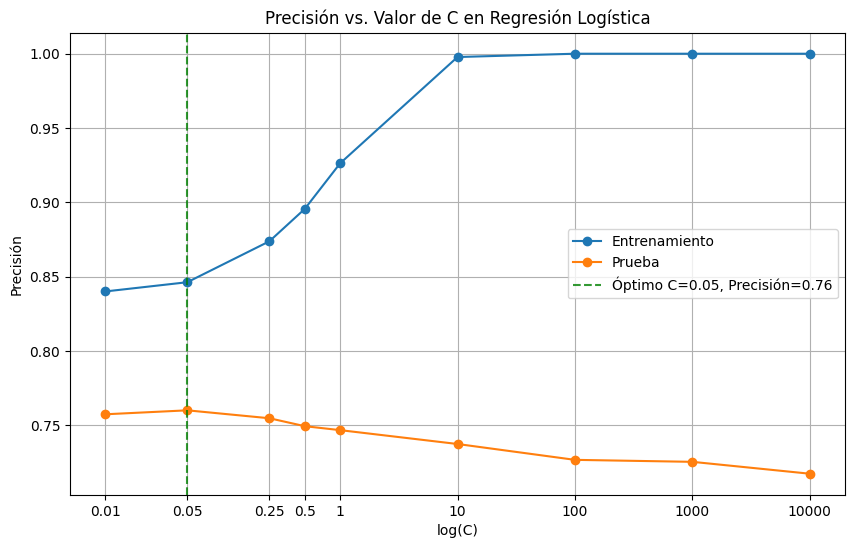

El valor óptimo de C es 0.05 con una precisión en el conjunto de prueba de 0.76


In [41]:

# Valores de C que deseas probar
C_values = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

# Listas para almacenar las precisiones
train_accuracies = []
test_accuracies = []

# Ajustar el modelo y registrar las precisiones para cada valor de C
for C in C_values:
    # Crear y entrenar un modelo de Regresión Logística con el valor de C actual
    lr_model = LogisticRegression(C=C, solver='lbfgs', max_iter=500)
    lr_model.fit(X_train_, y_train)

    # Predecir las etiquetas en el conjunto de entrenamiento y prueba
    train_predict = lr_model.predict(X_train_)
    test_predict = lr_model.predict(X_test_)

    # Calcular la precisión en el conjunto de entrenamiento y prueba
    train_accuracy = accuracy_score(y_train, train_predict)
    test_accuracy = accuracy_score(y_test, test_predict)

    # Registrar las precisiones en las listas
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Encontrar el valor óptimo de C basado en la precisión en el conjunto de prueba
optimal_C = C_values[np.argmax(test_accuracies)]
optimal_accuracy = max(test_accuracies)

# Crear el gráfico de precisión vs. valor de C
plt.figure(figsize=(10, 6))
plt.plot(np.log10(C_values), train_accuracies, marker='o', label='Entrenamiento')
plt.plot(np.log10(C_values), test_accuracies, marker='o', label='Prueba')
plt.axvline(np.log10(optimal_C), c='g', ls='--', alpha=0.8, label=f'Óptimo C={optimal_C}, Precisión={optimal_accuracy:.2f}')
plt.title('Precisión vs. Valor de C en Regresión Logística')
plt.xlabel('log(C)')
plt.ylabel('Precisión')
plt.xticks(np.log10(C_values), C_values)
plt.legend()
plt.grid(True)
plt.show()

print(f'El valor óptimo de C es {optimal_C} con una precisión en el conjunto de prueba de {optimal_accuracy:.2f}')


En teoría se podría mejorar el modelo poniendo una C = 0.05, en la práctica no me parece tan obvio.

Generamos el segundo modelo

In [42]:

mnb_model = MultinomialNB()
mnb_model.fit(X_train_, y_train)



MultinomialNB()

In [43]:
mnb_train_predict = mnb_model.predict(X_train_)
mnb_test_predict = mnb_model.predict(X_test_)
mnb_test_predict_proba = mnb_model.predict_proba(X_test_)[:, 1]

In [44]:

pickle.dump(mnb_model, open('data/mnb_model.pkl', 'wb'))

In [45]:
from sklearn.naive_bayes import MultinomialNB

# Inicializar y entrenar el modelo Naive Bayes Multinomial
mnb_model = MultinomialNB()
mnb_model.fit(X_train_, y_train)

# Predecir las etiquetas en el conjunto de entrenamiento y prueba
mnb_train_predict = mnb_model.predict(X_train_)
mnb_test_predict = mnb_model.predict(X_test_)

# Predecir las probabilidades en el conjunto de prueba
mnb_test_predict_proba = mnb_model.predict_proba(X_test_)[:, 1]


In [46]:

# Crear un DataFrame con todas las predicciones de ambos modelos
df_predictions = pd.DataFrame({
    'Actual Sentiment': y_test,
    'LR Test Predictions': test_predict,
    'LR Test Predictions Probabilities': lr_test_predict_proba,
    'MNB Test Predictions': mnb_test_predict,
    'MNB Test Predictions Probabilities': mnb_test_predict_proba
})

# Guardar las predicciones en un archivo CSV
df_predictions.to_csv('data/predictions.csv', index=False)

In [47]:
def print_model_metrics(y_test, y_test_predict):
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, y_test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, y_test_predict)))

In [48]:

# Inicializar y entrenar el modelo Naive Bayes Multinomial
mnb_model = MultinomialNB()
mnb_model.fit(X_train_, y_train)

# Calcular métricas para el conjunto de entrenamiento
# Predecir las etiquetas en el conjunto de entrenamiento
mnb_train_predict = mnb_model.predict(X_train_)
print("\n Training Set: \n")
# Calcular la matriz de confusión para el conjunto de entrenamiento
confusion_train = confusion_matrix(y_train, mnb_train_predict)
print('\nConfusion Matrix (Training Set):\n{}'.format(confusion_train))

# Mostrar el informe de clasificación para el conjunto de entrenamiento
classification_rep_train = classification_report(y_train, mnb_train_predict)
print('\nClassification Report (Training Set):\n{}'.format(classification_rep_train))

# Calcular y mostrar la puntuación de precisión para el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, mnb_train_predict)
print('Accuracy Score (Training Set): {}'.format(accuracy_train))

# Predecir las etiquetas en el conjunto de prueba
mnb_test_predict = mnb_model.predict(X_test_)

print("\n Test Set: \n")
# Calcular la matriz de confusión para el conjunto de prueba
confusion_test = confusion_matrix(y_test, mnb_test_predict)
print('Confusion Matrix (Test Set):\n{}'.format(confusion_test))

# Mostrar el informe de clasificación para el conjunto de prueba
classification_rep_test = classification_report(y_test, mnb_test_predict)
print('\nClassification Report (Test Set):\n{}'.format(classification_rep_test))

# Calcular y mostrar la puntuación de precisión para el conjunto de prueba
accuracy_test = accuracy_score(y_test, mnb_test_predict)
print('Accuracy Score (Test Set): {}'.format(accuracy_test))




 Training Set: 


Confusion Matrix (Training Set):
[[1056   69]
 [  59 1066]]

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1125
           1       0.94      0.95      0.94      1125

    accuracy                           0.94      2250
   macro avg       0.94      0.94      0.94      2250
weighted avg       0.94      0.94      0.94      2250

Accuracy Score (Training Set): 0.9431111111111111

 Test Set: 

Confusion Matrix (Test Set):
[[281  94]
 [ 94 281]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       375
           1       0.75      0.75      0.75       375

    accuracy                           0.75       750
   macro avg       0.75      0.75      0.75       750
weighted avg       0.75      0.75      0.75       750

Accuracy Score (Test Set): 0.7493333333333333


Observamos que ambos modelos son bastante similares, observamos que, tras varios intentos, el Multinomial Naive Bayes, da un resultado ligeramente superior tanto en training como en test. Ambos modelos también tardan lo mismo en realizar los cálculos, para el report, por tanto, escogeremos el Naive Bayes